In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from modules.benchmarks import MultiPeriodMeanVariance
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set()

In [2]:
config_file_name = "config.json"
with open(config_file_name, "r") as jsonfile:
    config_data = json.load(jsonfile)

In [3]:
sp100 = config_data["tickers"]["America"]["SP100"]
NUM_ASSETS = len(sp100)
len(sp100)

101

In [4]:
start_date = config_data["timeframe"]["sp100"]["start_date"]
end_date = config_data["timeframe"]["sp100"]["end_date"]
data_interval = config_data["data_interval"]
test_ratio = config_data["train_test_ratio"]
random_seed = config_data["random_state_seed"]

In [5]:
dataset = yf.download(sp100, 
                      start=start_date, 
                      end=end_date,
                      interval=data_interval)['Adj Close']
dataset.to_csv("data/raw/sp100_stocks_price.csv")

[*********************100%%**********************]  101 of 101 completed


In [6]:
dataset_price_change = dataset.pct_change().fillna(0)
dataset_return = dataset/dataset.shift(1).fillna(1)

In [7]:
NUM_ASSETS = len(dataset.columns.unique().tolist())

In [8]:
lookback_window = config_data["lookback_window"] # W
multi_step_horizon = config_data["multi_step_horizon"] # T
lookback_window, multi_step_horizon

(24, 3)

In [9]:
X_test_mpo = []
for i in range(len(dataset_price_change.values)-lookback_window):
    Sigmas = []
    mu = []
    for j in range(multi_step_horizon):
        cov_matrix_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].cov().values
        mu_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].mean(0).values
        Sigmas.append(cov_matrix_j)
        mu.append(mu_j)
    hist = dataset_return.iloc[i:i+lookback_window]
    pred = dataset_return.iloc[i+lookback_window:i+lookback_window+multi_step_horizon]
    X_test_mpo.append([hist, np.stack(mu), np.stack(Sigmas), pred])

len(X_test_mpo)

101

In [10]:
X_test_spo = []
for i in range(len(dataset_price_change.values)-lookback_window):
    Sigmas = []
    mu = []
    for j in range(1):
        cov_matrix_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].cov().values
        mu_j = dataset_price_change.iloc[i+j:i+j+lookback_window-multi_step_horizon].mean(0).values
        Sigmas.append(cov_matrix_j)
        mu.append(mu_j)
    hist = dataset_return.iloc[i:i+lookback_window]
    pred = dataset_return.iloc[i+lookback_window:i+lookback_window+multi_step_horizon]
    X_test_spo.append([hist, np.stack(mu), np.stack(Sigmas), pred])

len(X_test_spo)

101

Markowitz's Multi-Period Optimization

In [11]:
mean_variance_mpo = MultiPeriodMeanVariance(
    num_assets=NUM_ASSETS,
    multi_period_step=multi_step_horizon,
    min_individual_allocation=0.001,
    max_individual_allocation=0.25,
    risk_aversion_coefficient=1,
    trade_cost=0.0025,
    holding_cost=0
)

Markowitz's Single Period Optimization

In [12]:
mean_variance_spo = MultiPeriodMeanVariance(
    num_assets=NUM_ASSETS,
    multi_period_step=1,
    min_individual_allocation=0.001,
    max_individual_allocation=0.25,
    risk_aversion_coefficient=1,
    trade_cost=0.0025,
    holding_cost=0
)

In [13]:
result_mv_mpo = []
for hist, mu, Sigma, pred in X_test_mpo:
   if len(pred) < multi_step_horizon:
      continue
   mpo_opt_weights = mean_variance_mpo(mu, Sigma)
   portfolio_value_mpo = (mpo_opt_weights*pred).sum(1).prod()
   result_mv_mpo.append(portfolio_value_mpo)

In [14]:
result_mv_spo = []
for hist, mu, Sigma, pred in X_test_spo:
   spo_opt_weights = mean_variance_spo(mu, Sigma)
   portfolio_value_spo = (spo_opt_weights*pred).sum(1).prod()
   result_mv_spo.append(portfolio_value_spo)

In [15]:
result_mv_spo = result_mv_spo[:len(result_mv_mpo)]
len(result_mv_spo), len(result_mv_mpo)

(99, 99)

In [16]:
result_mv_mpo = pd.Series(result_mv_mpo, index=dataset[-len(result_mv_mpo):].index)
result_mv_mpo = result_mv_mpo.pct_change().fillna(0).cumsum()
len(result_mv_mpo)

99

In [17]:
result_mv_spo = pd.Series(result_mv_spo, index=dataset[-len(result_mv_spo):].index)
result_mv_spo = result_mv_spo.pct_change().fillna(0).cumsum()
len(result_mv_spo)

99

In [20]:
result_mv_spo += 1
result_mv_mpo += 1

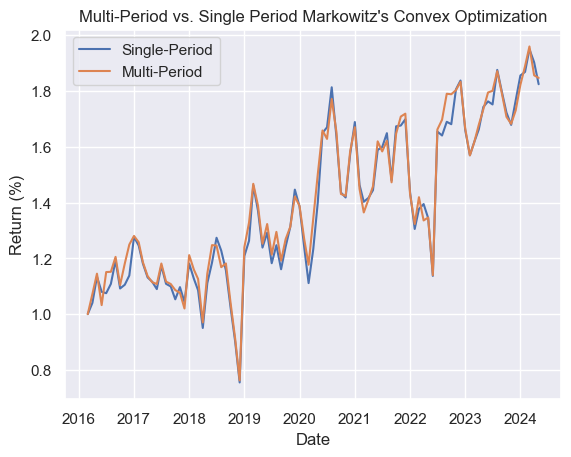

In [21]:
plt.plot(result_mv_spo.index, result_mv_spo, label='Single-Period')
plt.plot(result_mv_mpo.index, result_mv_mpo, label='Multi-Period')
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.title("Multi-Period vs. Single Period Markowitz's Convex Optimization")
plt.show()

Performance Metrics of MPO vs. SPO